# Create a GeoZarr with multi-scales containing the WebMercatorQuad TMS

While GeoZarr v0.4 is Zarr V2 specific, let's write a Zarr V3 store to get an idea about how GeoZarr could be adapted for Zarr format 3.

Following COG (Cloud Optimized GeoTIFF) conventions, the overviews maintain the native projection and use /2 downsampling logic.

## Load example dataset from NetCDF into Xarray

In [1]:
import os
os.environ["ZARR_V3_EXPERIMENTAL_API"] = "1"
import json

import cf_xarray  # noqa
import dask.array as da
import matplotlib.pyplot as plt
import morecantile
import numpy as np
import panel
import rasterio
import numcodecs
import rioxarray  # noqa
import xarray as xr
import zarr
import dask
from rio_tiler.io.xarray import XarrayReader

# Import our COG-style multiscale utilities
from geozarr_examples.cog_multiscales import (
    create_cog_style_overviews,
    verify_overview_coordinates,
    plot_overview_levels
)

In [2]:
fp_base = "S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458"
input = f"https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/{fp_base}.zarr"
v3_output = f"../output/v3/{fp_base}_multiscales.zarr"
from xarray.namedarray.parallelcompat import list_chunkmanagers
list_chunkmanagers()

{'dask': <xarray.namedarray.daskmanager.DaskManager at 0x7dfb423d6850>}

In [3]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
dt = xr.open_datatree(input, engine="zarr", chunks={})

/tmp/ipykernel_2702582/1043672829.py:4: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(input, engine="zarr", chunks={})
/tmp/ipykernel_2702582/1043672829.py:4: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 v

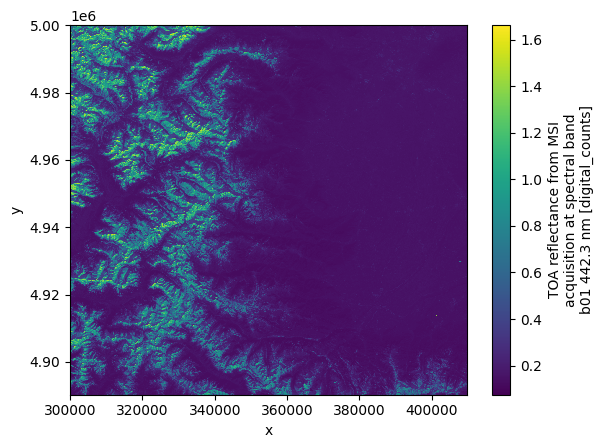

In [4]:
# Go to the measurements group
reflectance_ds = dt["measurements/reflectance"]
reflectance_ds.subtree
dt["measurements/reflectance/r60m"]["b01"].plot()

## Set CF standard names and CRS information for reflectance measurements


In [5]:
# in EOPF zarr the standard names are not set
# First loop over the reflectance groups
for group in reflectance_ds.groups:
    if not reflectance_ds[group].data_vars:
        # Skip groups with data variables
        continue
    print(group)
    standard_names = reflectance_ds[group].ds.cf.standard_names
    # Loop over the bands in the group
    for band in reflectance_ds[group].data_vars:
        print(band)
        # Check if the standard name is set
        if standard_names.get(band) is None:
            # If not set, assign the standard name based on the band name
            # and we are mapping them to standard names like "toa_bidirectional_reflectance"
            # You can modify this mapping as per your requirements
            standard_names[band] = "toa_bidirectional_reflectance"
            reflectance_ds[group][band].attrs["standard_name"] = "toa_bidirectional_reflectance"
            print(f"Setting standard name for {band} in group {group}")
        # check if the band has the proj:epsg attribute
        if "proj:epsg" in reflectance_ds[group][band].attrs:
            epsg = reflectance_ds[group][band].attrs["proj:epsg"]
            # If set, use it to create the crs
            print(f"Setting CRS for {band} in group {group} to EPSG:{epsg}")
            ds = reflectance_ds[group].ds.rio.write_crs(f"epsg:{epsg}")
            reflectance_ds[group][band].attrs["grid_mapping"] = "spatial_ref"

ds

/measurements/reflectance/r10m
b02
Setting standard name for b02 in group /measurements/reflectance/r10m
Setting CRS for b02 in group /measurements/reflectance/r10m to EPSG:32632
b03
Setting standard name for b03 in group /measurements/reflectance/r10m
Setting CRS for b03 in group /measurements/reflectance/r10m to EPSG:32632
b04
Setting standard name for b04 in group /measurements/reflectance/r10m
Setting CRS for b04 in group /measurements/reflectance/r10m to EPSG:32632
b08
Setting standard name for b08 in group /measurements/reflectance/r10m
Setting CRS for b08 in group /measurements/reflectance/r10m to EPSG:32632
/measurements/reflectance/r20m
b05
Setting standard name for b05 in group /measurements/reflectance/r20m
Setting CRS for b05 in group /measurements/reflectance/r20m to EPSG:32632
b06
Setting standard name for b06 in group /measurements/reflectance/r20m
Setting CRS for b06 in group /measurements/reflectance/r20m to EPSG:32632
b07
Setting standard name for b07 in group /measur

<xarray.Dataset> Size: 80MB
Dimensions:      (y: 1830, x: 1830)
Coordinates:
  * x            (x) int64 15kB 300030 300090 300150 ... 409650 409710 409770
  * y            (y) int64 15kB 5000010 4999950 4999890 ... 4890330 4890270
    spatial_ref  int64 8B 0
Data variables:
    b01          (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    b09          (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>
    b10          (y, x) float64 27MB dask.array<chunksize=(305, 305), meta=np.ndarray>

## Specify that the band `b01` will contain multiscales

In [6]:
var = "b01"
tileWidth = 256
min_dimension = 256  # Stop creating overviews when dimension is smaller than this

# Get native resolution dimensions for calculating overview levels
native_height, native_width = ds[var].shape[-2:]
print(f"Native resolution: {native_width} x {native_height}")
print(f"Native CRS: {ds.rio.crs}")

# Calculate how many overview levels we'll have
from geozarr_examples.cog_multiscales import calculate_overview_levels
overview_levels = calculate_overview_levels(native_width, native_height, min_dimension, tileWidth)

# Update multiscales metadata with actual overview levels
tile_matrix_limits = {str(ol['level']): {} for ol in overview_levels}

ds["b01"].attrs["multiscales"] = {
    "tile_matrix_set": "WebMercatorQuad",
    "resampling_method": "nearest",
    "tile_matrix_limits": tile_matrix_limits,
}
ds["b01"]

Native resolution: 1830 x 1830
Native CRS: EPSG:32632


<xarray.DataArray 'b01' (y: 1830, x: 1830)> Size: 27MB
dask.array<open_dataset-b01, shape=(1830, 1830), dtype=float64, chunksize=(305, 305), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) int64 15kB 300030 300090 300150 ... 409650 409710 409770
  * y            (y) int64 15kB 5000010 4999950 4999890 ... 4890330 4890270
    spatial_ref  int64 8B 0
Attributes: (12/14)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    dtype:           <u2
    fill_value:      0
    long_name:       TOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [300000.0, 4890240.0, 409800.0, 5000040.0]
    proj:epsg:       32632
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    standard_name:   toa_bidirectional_reflectance
    multiscales:     {'tile_matrix_set': 'WebMercatorQuad', 'resampling_metho...

## Specify encoding and write to Zarr V3 format

In [7]:
from zarr.codecs import BloscCodec
spatial_chunk = 4096
compressor = BloscCodec(cname="zstd", clevel=3, shuffle='shuffle', blocksize=0)

encoding = {
    "b01": {
        "chunks": (1, spatial_chunk, spatial_chunk),
        "compressors": compressor,
    },
    "b09": {
        "chunks": (1, spatial_chunk, spatial_chunk),
        "compressors": compressor,
    },
    "b10": {
        "chunks": (1, spatial_chunk, spatial_chunk),
        "compressors": compressor,
    },
}
for coord in ds.coords:
    encoding[coord] = {"compressors": None}
    
ds.to_zarr(v3_output, mode="w", consolidated=True, zarr_format=3, encoding=encoding)

/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/.venv/lib/python3.11/site-packages/zarr/api/asynchronous.py:213: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


## Create COG-style overview levels

This uses our helper functions to create overview levels that:
- Maintain the native projection (UTM)
- Use /2 downsampling logic
- Include proper coordinate arrays
- Follow COG conventions

In [8]:
# Create COG-style overview levels using our helper function
overview_levels = create_cog_style_overviews(
    ds=ds,
    var=var,
    v3_output=v3_output,
    min_dimension=min_dimension,
    tileWidth=tileWidth
)

Native resolution: 1830 x 1830
Native CRS: EPSG:32632
Native bounds: (300000.0, 4890240.0, 409800.0, 5000040.0)

Total overview levels: 3
Overview level 0: 1830 x 1830 (TMS zoom: 3, scale factor: 1)
Overview level 1: 915 x 915 (TMS zoom: 2, scale factor: 2)
Overview level 2: 457 x 457 (TMS zoom: 1, scale factor: 4)
Creating template for level 0: 1830x1830 pixels in native CRS EPSG:32632
Created template for overview level 0
Creating template for level 1: 915x915 pixels in native CRS EPSG:32632
Created template for overview level 1
Creating template for level 2: 457x457 pixels in native CRS EPSG:32632
Created template for overview level 2

Created 3 overview levels in native CRS
Native data shape: (1830, 1830)

Processing overview level 0 (1:1 scale)...
Target dimensions: 1830 x 1830
Level 0: Successfully populated with downsampled data

Processing overview level 1 (1:2 scale)...
Target dimensions: 915 x 915
Level 1: Successfully populated with downsampled data

Processing overview leve

## Consolidate metadata at the root of the Zarr store

In [9]:
zarr.consolidate_metadata(v3_output)

/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/.venv/lib/python3.11/site-packages/zarr/api/asynchronous.py:213: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


<Group file://../output/v3/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458_multiscales.zarr>

## Inspect Zarr V3 store

In [10]:
root = zarr.open_group(v3_output, mode="r")
root.tree()

/
├── 0
│   ├── b01 (1830, 1830) float32
│   ├── spatial_ref () int64
│   ├── x (1830,) float64
│   └── y (1830,) float64
├── 1
│   ├── b01 (915, 915) float32
│   ├── spatial_ref () int64
│   ├── x (915,) float64
│   └── y (915,) float64
├── 2
│   ├── b01 (457, 457) float32
│   ├── spatial_ref () int64
│   ├── x (457,) float64
│   └── y (457,) float64
├── b01 (1830, 1830) float64
├── b09 (1830, 1830) float64
├── b10 (1830, 1830) float64
├── spatial_ref () int64
├── x (1830,) int64
└── y (1830,) int64

## Verify coordinates and CRS are maintained in overview levels

In [11]:
# Verify that coordinates and CRS are properly maintained
verify_overview_coordinates(
    v3_output=v3_output,
    overview_levels=overview_levels,
    native_crs=ds.rio.crs,
    max_levels=3
)

Checking coordinates and CRS in overview levels:

Level 0:
  Variables: ['b01']
  Coordinates: ['spatial_ref', 'x', 'y']
  Dimensions: {'y': 1830, 'x': 1830}
  CRS: EPSG:32632
  Spatial_ref attrs: ['crs_wkt', 'semi_major_axis', 'semi_minor_axis', 'inverse_flattening', 'reference_ellipsoid_name', 'longitude_of_prime_meridian', 'prime_meridian_name', 'geographic_crs_name', 'horizontal_datum_name', 'projected_crs_name', 'grid_mapping_name', 'latitude_of_projection_origin', 'longitude_of_central_meridian', 'false_easting', 'false_northing', 'scale_factor_at_central_meridian', 'spatial_ref']
  X range: 300000.00 to 409740.00
  Y range: 4890300.00 to 5000040.00
  ✓ Coordinates present in native CRS
  ✓ Native CRS maintained: EPSG:32632

Level 1:
  Variables: ['b01']
  Coordinates: ['y', 'x', 'spatial_ref']
  Dimensions: {'y': 915, 'x': 915}
  CRS: EPSG:32632
  Spatial_ref attrs: ['crs_wkt', 'semi_major_axis', 'semi_minor_axis', 'inverse_flattening', 'reference_ellipsoid_name', 'longitude_of_

## Plot overview levels using xarray's native plot() method

This demonstrates that the coordinate system is properly maintained in the native CRS and that xarray can automatically use the coordinates for spatial plotting.

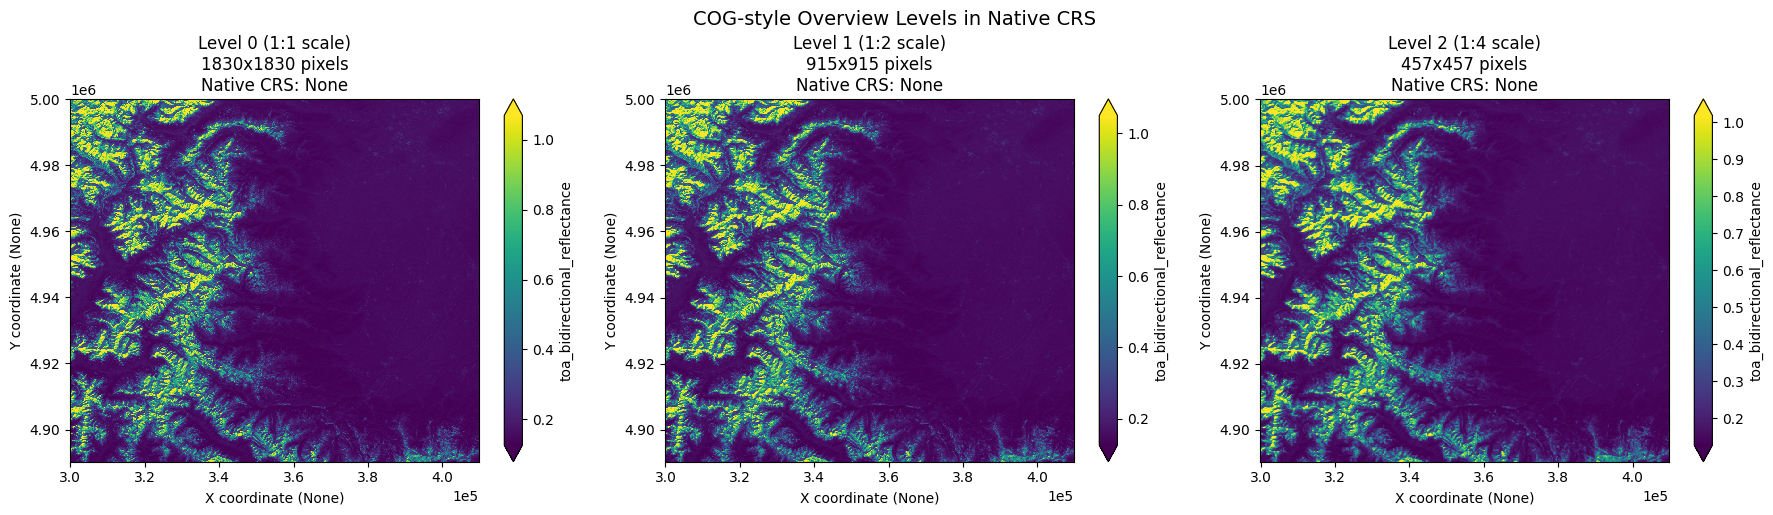


xarray.plot() successfully used coordinates for spatial plotting!
This demonstrates that the coordinate arrays are properly set up and recognized by xarray.


In [12]:
# Plot overview levels using xarray's native plotting
fig = plot_overview_levels(
    v3_output=v3_output,
    overview_levels=overview_levels,
    var=var,
    max_plots=3
)

print("\nxarray.plot() successfully used coordinates for spatial plotting!")
print("This demonstrates that the coordinate arrays are properly set up and recognized by xarray.")

## Summary

This notebook demonstrates how to create COG-style multiscale GeoZarr datasets that:

### ✅ **Follow COG Conventions**:
- Overviews maintain the native projection (UTM in this case)
- Use /2 downsampling logic (1:1, 1:2, 1:4, 1:8, etc.)
- Stop when dimensions become smaller than 256 pixels

### ✅ **Maintain Geospatial Integrity**:
- Each overview level has proper x/y coordinate arrays
- Native CRS is preserved across all levels
- Proper geotransform information is maintained
- CF-compliant metadata and standard names

### ✅ **Enable Efficient Access**:
- Compatible with WebMercatorQuad TMS for serving
- Zarr V3 format with efficient compression
- Consolidated metadata for fast access
- Proper chunking for cloud-optimized access

### ✅ **Work with Standard Tools**:
- xarray automatically recognizes coordinates for plotting
- rioxarray can work with the CRS information
- Compatible with existing geospatial Python ecosystem

The helper functions in `geozarr_examples.cog_multiscales` make it easy to create these COG-style multiscale datasets while following best practices for geospatial data management.